<a href="https://colab.research.google.com/github/AfsaneHeydari/AutoEncoder-based-communication-system-simulation/blob/main/Com_AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing libs
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K

In [ ]:

# for reproducing reslut
from numpy.random import seed
seed(1)
tf.random.set_seed(3)

In [ ]:
class CommunicationSys():

  def __init__(self,n,k,model_summary,represent):
    self.k = k
    self.M = 2**k
    M = self.M
    self.k = int(self.k)
    self.n_channel = n
    R = self.k/self.n_channel
    print ('M:',self.M,'k:',self.k,'n:',self.n_channel)


    self.input_signal = Input(shape=(M,))
    self.encoded = Dense(M, activation='relu')(self.input_signal)
    self.encoded1 = Dense(self.n_channel, activation='linear')(self.encoded)
    self.encoded2 = Lambda(lambda x: np.sqrt(self.n_channel)*K.l2_normalize(x,axis=1))(self.encoded1)

    EbNo_train = 5.01187 #  coverted 7 db of EbNo
    self.encoded3 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(self.encoded2)

    self.decoded = Dense(M, activation='relu')(self.encoded3)
    self.decoded1 = Dense(M, activation='softmax')(self.decoded)
    self.autoencoder = Model(self.input_signal, self.decoded1)
    adam = Adam(lr=0.01)
    self.autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')

    if model_summary == 1:
      print(self.autoencodersummary())

    data = self.dataGen(self.M,self.n_channel)
    self.autoencoder.fit(data, data,
                epochs=45,
                batch_size=32)
    
    encoder = Model(self.input_signal, self.encoded2)
    # making decoder from full autoencoder
    encoded_input = Input(shape=(self.n_channel,))

    deco = self.autoencoder.layers[-2](encoded_input)
    deco = self.autoencoder.layers[-1](deco)
    decoder = Model(encoded_input, deco)

    N = 50000
    test_label = np.random.randint(M,size=N)
    test_data = []

    for i in test_label:
        temp = np.zeros(M)
        temp[i] = 1
        test_data.append(temp)
        
    test_data = np.array(test_data)

    scatter_plot = []
    for i in range(0,M):
        temp = np.zeros(M)
        temp[i] = 1
        scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))

    scatter_plot = np.array(scatter_plot)
    print (scatter_plot.shape)
    if (represent == 1):
      import matplotlib.pyplot as plt
      scatter_plot = scatter_plot.reshape(M,2,1)
      plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
      plt.axis((-2.5,2.5,-2.5,2.5))
      plt.grid()
      plt.show()

    self.EbNodB_range = list(self.frange(-4,8.5,0.5))
    self.ber = [None]*len(self.EbNodB_range)
    for n in range(0,len(self.EbNodB_range)):
        EbNo=10.0**(self.EbNodB_range[n]/10.0)
        noise_std = np.sqrt(1/(2*R*EbNo))
        noise_mean = 0
        no_errors = 0
        nn = N
        noise = noise_std * np.random.randn(nn,self.n_channel)
        encoded_signal = encoder.predict(test_data) 
        final_signal = encoded_signal + noise
        pred_final_signal =  decoder.predict(final_signal)
        pred_output = np.argmax(pred_final_signal,axis=1)
        no_errors = (pred_output != test_label)
        no_errors =  no_errors.astype(int).sum()
        self.ber[n] = no_errors / nn 

    import matplotlib.pyplot as plt
    from scipy import interpolate
    plt.plot(self.EbNodB_range, self.ber, 'bo',label='Autoencoder({},{})'.format(n,k))
    plt.yscale('log')
    plt.xlabel('SNR Range')
    plt.ylabel('Block Error Rate')
    plt.grid()
    plt.legend(loc='upper right',ncol = 1)
    plt.show()



  def dataGen(self,M,N):
    N = 8000
    label = np.random.randint(M,size=N)

    data = []
    for i in label:
        temp = np.zeros(M)
        temp[i] = 1
        data.append(temp)

    data = np.array(data)
    return data

  def frange(self,x, y, jump):
    while x < y:
      yield x
      x += jump


    

M: 4 k: 2 n: 2
Epoch 1/45
250/250 [==============================] - 0s 2ms/step - loss: 0.5909
Epoch 2/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0254
Epoch 3/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0141
Epoch 4/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 5/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0092
Epoch 6/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 7/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0087
Epoch 8/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 9/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0071
Epoch 10/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0062
Epoch 11/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0068
Epoch 12/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0060
Epoch 13/4

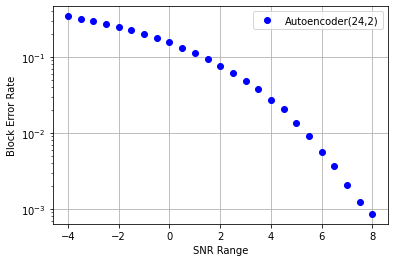

In [ ]:
cs1 = CommunicationSys(2,2,0,0)

M: 16 k: 4 n: 2
Epoch 1/45
250/250 [==============================] - 0s 2ms/step - loss: 1.1303
Epoch 2/45
250/250 [==============================] - 0s 2ms/step - loss: 0.6362
Epoch 3/45
250/250 [==============================] - 0s 2ms/step - loss: 0.5985
Epoch 4/45
250/250 [==============================] - 1s 2ms/step - loss: 0.5767
Epoch 5/45
250/250 [==============================] - 0s 2ms/step - loss: 0.5920
Epoch 6/45
250/250 [==============================] - 0s 2ms/step - loss: 0.5701
Epoch 7/45
250/250 [==============================] - 0s 2ms/step - loss: 0.5770
Epoch 8/45
250/250 [==============================] - 0s 2ms/step - loss: 0.5667
Epoch 9/45
250/250 [==============================] - 0s 2ms/step - loss: 0.5760
Epoch 10/45
250/250 [==============================] - 0s 2ms/step - loss: 0.5491
Epoch 11/45
250/250 [==============================] - 1s 2ms/step - loss: 0.5659
Epoch 12/45
250/250 [==============================] - 0s 2ms/step - loss: 0.5616
Epoch 13/

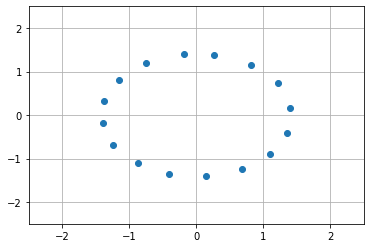

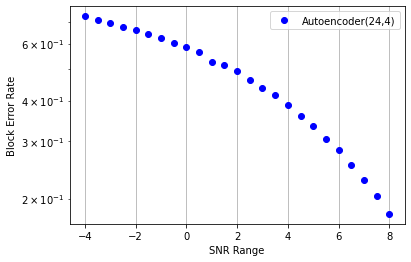

In [ ]:
cs2 = CommunicationSys(2,4,0,1)

M: 16 k: 4 n: 7
Epoch 1/45
250/250 [==============================] - 0s 2ms/step - loss: 0.3542
Epoch 2/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0227
Epoch 3/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 4/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 5/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 6/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 7/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0098
Epoch 8/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0089
Epoch 9/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 10/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0107
Epoch 11/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 12/45
250/250 [==============================] - 0s 2ms/step - loss: 0.0103
Epoch 13/

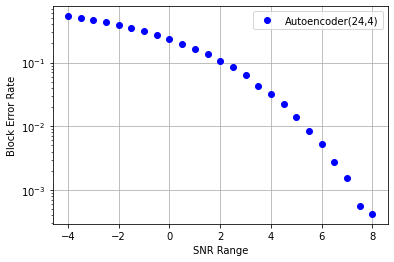

In [ ]:
cs3 = CommunicationSys(7,4,0,0)

M: 256 k: 8 n: 8
Epoch 1/45
250/250 [==============================] - 1s 2ms/step - loss: 1.7540
Epoch 2/45
250/250 [==============================] - 1s 2ms/step - loss: 0.3140
Epoch 3/45
250/250 [==============================] - 1s 2ms/step - loss: 0.2147
Epoch 4/45
250/250 [==============================] - 1s 2ms/step - loss: 0.2102
Epoch 5/45
250/250 [==============================] - 1s 2ms/step - loss: 0.1861
Epoch 6/45
250/250 [==============================] - 1s 2ms/step - loss: 0.1644
Epoch 7/45
250/250 [==============================] - 1s 2ms/step - loss: 0.2050
Epoch 8/45
250/250 [==============================] - 1s 2ms/step - loss: 0.1600
Epoch 9/45
250/250 [==============================] - 1s 2ms/step - loss: 0.1480
Epoch 10/45
250/250 [==============================] - 1s 2ms/step - loss: 0.1158
Epoch 11/45
250/250 [==============================] - 1s 2ms/step - loss: 0.1195
Epoch 12/45
250/250 [==============================] - 1s 2ms/step - loss: 0.1830
Epoch 13

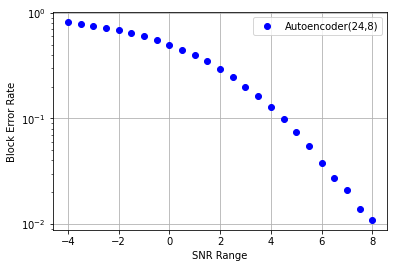

In [ ]:
cs4 = CommunicationSys(8,8,0,0)

Text(0.5, 0, 'SNR')

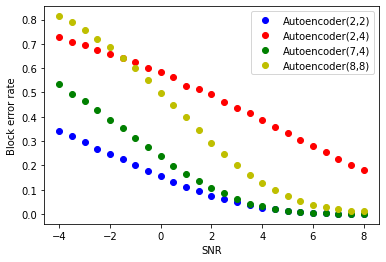

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cs1.EbNodB_range, cs1.ber, 'bo')
plt.plot(cs2.EbNodB_range, cs2.ber, 'ro')
plt.plot(cs3.EbNodB_range, cs3.ber, 'go')
plt.plot(cs4.EbNodB_range, cs4.ber, 'yo')
plt.legend(['Autoencoder({},{})'.format(cs1.n_channel,cs1.k),
           'Autoencoder({},{})'.format(cs2.n_channel,cs2.k),
           'Autoencoder({},{})'.format(cs3.n_channel,cs3.k),
           'Autoencoder({},{})'.format(cs4.n_channel,cs4.k)])
plt.ylabel('Block error rate')
plt.xlabel('SNR')